# Predicting house prices using k-nearest neighbors regression

In [1]:
import pandas as pd
import numpy as np

In [2]:
sales = pd.read_csv('kc_house_data_small.csv')

In [3]:
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.as_matrix()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.as_matrix()
    return(feature_matrix, output_array)

In [5]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix,axis = 0)
    normalized_features = feature_matrix/norms
    return normalized_features,norms

## Split data into training, test, and validation sets

In [6]:
train = pd.read_csv('kc_house_data_small_train.csv')
validation = pd.read_csv('kc_house_data_validation.csv')
test = pd.read_csv('kc_house_data_small_test.csv')

## Extract features and normalize

In [7]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

d:\anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
d:\anaconda\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [8]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

## Compute a single distance

In [9]:
features_test[0]

array([ 0.01345102,  0.01551285,  0.01807473,  0.01759212,  0.00160518,
        0.017059  ,  0.        ,  0.05102365,  0.0116321 ,  0.01564352,
        0.01362084,  0.02481682,  0.01350306,  0.        ,  0.01345387,
       -0.01346922,  0.01375926,  0.0016225 ])

In [11]:
features_train[9]

array([ 0.01345102,  0.01163464,  0.00602491,  0.0083488 ,  0.00050756,
        0.01279425,  0.        ,  0.        ,  0.01938684,  0.01390535,
        0.0096309 ,  0.        ,  0.01302544,  0.        ,  0.01346821,
       -0.01346251,  0.01195898,  0.00156612])

In [12]:
np.linalg.norm(features_test[0]-features_train[9])

0.05972359371398078

## Compute multiple distances

In [13]:
Euclidean_distance = []
for i in range(10):
    Euclidean_distance.append(np.linalg.norm(features_test[0]-features_train[i]))

In [14]:
np.argmin(Euclidean_distance)

8

## Perform 1-nearest neighbor regression

In [15]:
diff = [ features_train[i] - features_test[0] for i in range(0,len(features_train))]

In [16]:
print(diff[-1].sum())

-0.09343399874654643


In [21]:
np.sum(np.square(diff), axis=1)[15]

0.0033070590284564453

In [20]:
np.sum(np.square(diff[15]))

0.0033070590284564453

In [22]:
def compute_distances(features_instances, features_query):
    return np.sqrt(np.sum(np.square(features_instances - features_query), axis=1))

In [24]:
dis = compute_distances(features_train,features_test[2])
np.argmin(dis)

382

In [25]:
train.iloc[382]['price']

249000

## Perform k-nearest neighbor regression

In [26]:
def k_nearest_neighbors(k, feature_train, features_query):
    distances = compute_distances(feature_train,features_query)
    neighbors = np.argsort(distances)
    return neighbors[0:k]

In [27]:
neighbors = k_nearest_neighbors(4,features_train,features_test[2])
neighbors

array([ 382, 1149, 4087, 3142], dtype=int64)

In [28]:
def predict_output_of_query(k, features_train, output_train, features_query):
    neighbors = k_nearest_neighbors(k,features_train,features_query)
    output_price = output_train[neighbors]
    prediction = output_price.mean()
    return prediction

In [29]:
value = predict_output_of_query(4, features_train, output_train, features_test[2])
value

413987.5

## Make multiple predictions

In [30]:
def predict_output(k, features_train, output_train, features_query):
    predictions = list()
    for i in range(0,np.shape(features_query)[0]):
        predictions.append(predict_output_of_query(k, features_train, output_train, features_query[i]))
    return predictions

In [31]:
prediction_10 = predict_output(10,features_train,output_train,features_test[0:10])
np.argsort(prediction_10)

array([6, 3, 1, 9, 2, 8, 7, 5, 4, 0], dtype=int64)

In [32]:
prediction_10[6]

350032.0

## Choosing the best value of k using a validation set

In [33]:
rss_all = []
for k in range(1, 16):
    predictions = predict_output(k, features_train, output_train, features_valid)
    RSS = np.sum(np.square(predictions-output_valid))
    print(k, RSS)
    rss_all.append(RSS)

1 105453830251561.0
2 83445073504025.5
3 72692096019202.56
4 71946721652091.69
5 69846517419718.6
6 68899544353180.836
7 68341973450051.09
8 67361678735491.5
9 68372727958976.09
10 69335048668556.74
11 69523855215598.83
12 69049969587246.17
13 70011254508263.69
14 70908698869034.34
15 71106928385945.16


In [34]:
np.argmin(rss_all)+1

8

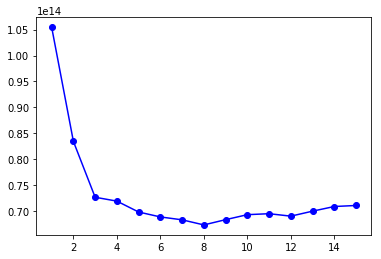

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')

In [36]:
prediction_8 = predict_output(8,features_train,output_train,features_test)

In [37]:
np.sum(np.square(prediction_8-output_test))

133118823551516.81